# 9. Fashion MNIST serialization

In [ ]:
from itertools import cycle

import tensorflow_datasets as tfds

from tensorflow.train import BytesList, Int64List, Feature, Features, Example
from tensorflow.io import TFRecordWriter, serialize_tensor, FixedLenFeature, parse_single_example, parse_tensor
from tensorflow.data import TFRecordDataset, Dataset

from tensorflow import string, int64, uint8, reshape

import tensorflow

import matplotlib.pyplot as plt

import time

from contextlib import ExitStack

from keras.api.models import Sequential
from keras.api.layers import Input, Flatten, Dense, Normalization
from keras.api.callbacks import TensorBoard

import numpy as np

from datetime import datetime

from pathlib import Path

tensorflow.random.set_seed(42)

2025-02-12 18:55:03.788702: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739382903.826574  108909 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739382903.839662  108909 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-12 18:55:03.923703: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
def benchmark(dataset, num_epochs=2):
    start_time = time.perf_counter()
    for epoch_num in range(num_epochs):
        for sample in dataset:
            # Performing a training step
            time.sleep(0.01)
    print("Execution time:", time.perf_counter() - start_time)

In [4]:
def plot_images(dataset, num_images=10):
    plt.figure(figsize=(10, 10))
    for i, (X, y) in enumerate(dataset.take(num_images)):
        image = X
        label = y.numpy()
        plt.subplot(5, 2, i + 1)
        plt.imshow(image.numpy().squeeze(), cmap='gray')
        plt.title(f'Label: {label}')
        plt.axis('off')
    plt.show()

## a.
_Exercise: Load the Fashion MNIST dataset (introduced in Chapter 10); split it into a training set, a validation set, and a test set; shuffle the training set; and save each dataset to multiple TFRecord files. Each record should be a serialized `Example` protobuf with two features: the serialized image (use `tf.io.serialize_tensor()` to serialize each image), and the label. Note: for large images, you could use `tf.io.encode_jpeg()` instead. This would save a lot of space, but it would lose a bit of image quality._

In [5]:
train_set, valid_set, test_set = tfds.load(
    name="fashion_mnist",
    split=["train[:90%]", "train[90%:]", "test"],
    as_supervised=True
)

I0000 00:00:1739382910.346104  108909 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2874 MB memory:  -> device: 0, name: Quadro P600, pci bus id: 0000:01:00.0, compute capability: 6.1


In [6]:
train_set = train_set.shuffle(10_000, seed=42).prefetch(1)
valid_set = valid_set.cache()
test_set = test_set.cache()

In [7]:
print(len(train_set))
print(len(valid_set))
print(len(test_set))

54000
6000
10000


2025-02-12 18:55:12.154866: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:376] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608
2025-02-12 18:55:12.691691: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2025-02-12 18:55:12.705178: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


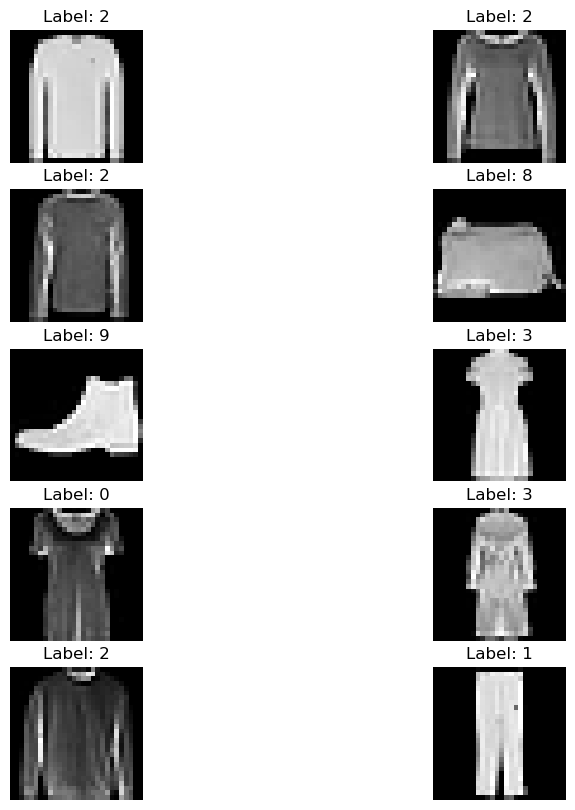

In [8]:
plot_images(train_set)

In [9]:
for X, y in train_set.take(1):
    print(X.shape)
    print(y.shape)


(28, 28, 1)
()


2025-02-12 18:55:13.445233: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2025-02-12 18:55:13.449566: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [10]:
def getFilepaths(filename, num_files=10):
    return ["{}_{}.tfrecord".format(filename, i) for i in range(num_files)]

In [11]:
def saveToTFRecord(filename, dataset):
    filepaths = getFilepaths(filename)

    with ExitStack() as stack:
        writers = cycle([stack.enter_context(TFRecordWriter(path)) for path in filepaths])
        for X, y in dataset:
            writer = next(writers)
                
            example = Example(
                features=Features(
                    feature={
                        "image": Feature(
                            bytes_list=BytesList(value=[serialize_tensor(X).numpy()])
                        ),
                        "label": Feature(int64_list=Int64List(value=[y])),
                    }
                )
            )
            writer.write(example.SerializeToString())


saveToTFRecord("train_fashion_mnist", train_set)
saveToTFRecord("valid_fashion_mnist", valid_set)
saveToTFRecord("test_fashion_mnist", test_set)

2025-02-12 18:55:33.302228: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## b.
_Exercise: Then use tf.data to create an efficient dataset for each set. Finally, use a Keras model to train these datasets, including a preprocessing layer to standardize each input feature. Try to make the input pipeline as efficient as possible, using TensorBoard to visualize profiling data._

In [ ]:
feature_description = {
    "image": FixedLenFeature([], string),
    "label": FixedLenFeature([], int64),
}


def parse(serialized_example):
    example = parse_single_example(serialized_example, feature_description)
    image = parse_tensor(example["image"], out_type=uint8)
    image = reshape(image, shape=[28, 28])
    label = example["label"]
    return image, label

In [35]:
def loadFromTFRecord(filename, shuffle=False):
    filepaths = getFilepaths(filename)
    dataset = Dataset.from_tensor_slices(filepaths)
    dataset = dataset.interleave(
        lambda filepath: TFRecordDataset(filepath, num_parallel_reads=5),
        num_parallel_calls=5,
    )
    dataset = dataset.cache()
    if (shuffle):
        dataset = dataset.shuffle(60_000)
    dataset = dataset.map(parse, num_parallel_calls=5)
    return dataset

recovered_train_set = loadFromTFRecord("train_fashion_mnist", True)
recovered_valid_set = loadFromTFRecord("valid_fashion_mnist")
recovered_test_set = loadFromTFRecord("test_fashion_mnist")

In [63]:
benchmark(recovered_train_set.take(1))

Execution time: 0.2043453500009491


In [36]:
print(len(list(recovered_train_set)))
print(len(list(recovered_valid_set)))
print(len(list(recovered_test_set)))

54000


2025-02-12 21:33:42.079395: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


6000
10000


In [37]:
for X, y in recovered_train_set.take(1):
    print(X.shape)
    print(y.shape)

(28, 28)
()


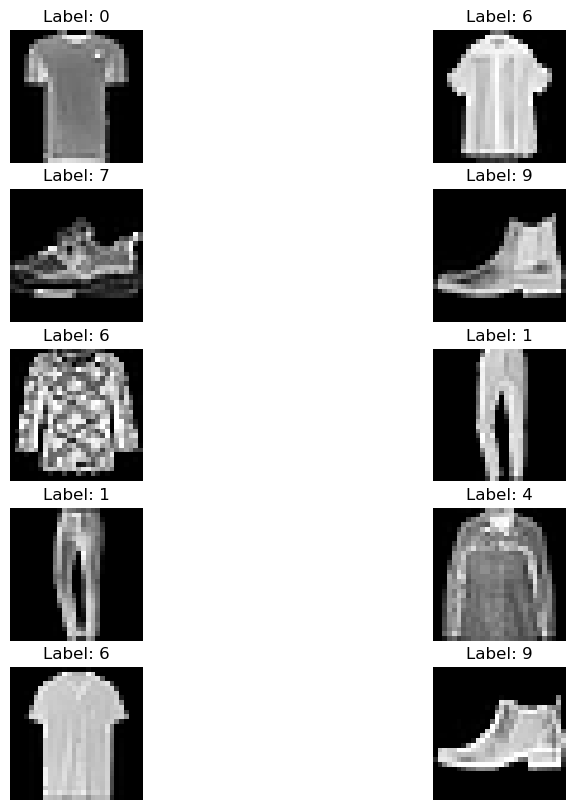

In [38]:
plot_images(recovered_train_set)

In [ ]:
batch_train_set = recovered_train_set.batch(32).prefetch(1)
batch_valid_set = recovered_valid_set.batch(32).prefetch(1)
batch_test_set = recovered_test_set.batch(32).prefetch(1)

In [ ]:
normalization = Normalization()

sample_image_batches = batch_train_set.take(100).map(lambda image, label: image)
sample_images = np.concatenate(list(sample_image_batches.as_numpy_iterator()), axis=0).astype(np.float32)
normalization.adapt(sample_images)

model = Sequential()
model.add(Input((28, 28)))
model.add(normalization)
model.add(Flatten())
model.add(Dense(100, activation="relu"))
model.add(Dense(10, activation="softmax"))

model.compile(optimizer="nadam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_5 (Normalization) │ (None, 28, 28)         │            57 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_12 (Flatten)            │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 100)            │        78,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,567 (310.81 KB)

 Trainable params: 79,510 (310.59 KB)

 Non-trainable params: 57 (232.00 B)

In [ ]:
logs = Path() / "my_logs" / "run_" / datetime.now().strftime("%Y%m%d_%H%M%S")

tensorboard_cb = TensorBoard(
    log_dir=logs, histogram_freq=1, profile_batch=10)

model.fit(batch_train_set, epochs=5, validation_data=batch_valid_set, callbacks=[tensorboard_cb])

Epoch 1/5


2025-02-12 21:37:08.102580: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:103] Profiler session initializing.
2025-02-12 21:37:08.102643: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:118] Profiler session started.
2025-02-12 21:37:08.121294: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:130] Profiler session tear down.
2025-02-12 21:37:08.127122: I external/local_xla/xla/backends/profiler/gpu/cupti_tracer.cc:1213] CUPTI activity buffer flushed


     10/Unknown 1s 16ms/step - accuracy: 0.2550 - loss: 2.1485

2025-02-12 21:37:09.436760: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion', 4 bytes spill stores, 16 bytes spill loads

2025-02-12 21:37:09.507488: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:103] Profiler session initializing.
2025-02-12 21:37:09.507544: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:118] Profiler session started.
2025-02-12 21:37:09.577236: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:68] Profiler session collecting data.
2025-02-12 21:37:09.584131: I external/local_xla/xla/backends/profiler/gpu/cupti_tracer.cc:1213] CUPTI activity buffer flushed
2025-02-12 21:37:09.594898: I external/local_xla/xla/backends/profiler/gpu/cupti_collector.cc:635]  GpuTracer has collected 34 callback api events and 34 activity events. 
2025-02-12 21:37:09.594952: I external/local_xla/xla/backends/profiler/gpu/cupti_collector.cc:638]  

   1688/Unknown 12s 6ms/step - accuracy: 0.8029 - loss: 0.5572

2025-02-12 21:37:20.239715: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion', 4 bytes spill stores, 16 bytes spill loads

2025-02-12 21:37:20.254602: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10125472825172607396
2025-02-12 21:37:20.254689: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14522188240616204254
/home/martin/miniconda/lib/python3.12/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


1688/1688 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.8029 - loss: 0.5571 - val_accuracy: 0.8675 - val_loss: 0.3713
Epoch 2/5
1683/1688 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8762 - loss: 0.3360

2025-02-12 21:37:31.637435: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10125472825172607396
2025-02-12 21:37:31.637513: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14522188240616204254


1688/1688 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.8762 - loss: 0.3360 - val_accuracy: 0.8773 - val_loss: 0.3368
Epoch 3/5
1682/1688 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8895 - loss: 0.2962

2025-02-12 21:37:42.449188: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10125472825172607396
2025-02-12 21:37:42.449270: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14522188240616204254


1688/1688 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.8895 - loss: 0.2962 - val_accuracy: 0.8792 - val_loss: 0.3428
Epoch 4/5
  11/1688 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.8746 - loss: 0.3199   

2025-02-12 21:37:42.835188: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10125472825172607396
2025-02-12 21:37:42.835275: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14522188240616204254


1681/1688 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8973 - loss: 0.2749

2025-02-12 21:37:53.182774: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10125472825172607396
2025-02-12 21:37:53.182858: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14522188240616204254


1688/1688 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.8973 - loss: 0.2749 - val_accuracy: 0.8802 - val_loss: 0.3371
Epoch 5/5
  10/1688 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.9130 - loss: 0.2244   

2025-02-12 21:37:53.579415: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10125472825172607396
2025-02-12 21:37:53.579491: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14522188240616204254


1686/1688 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9064 - loss: 0.2532

2025-02-12 21:38:04.439026: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10125472825172607396
2025-02-12 21:38:04.439123: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14522188240616204254


1688/1688 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.9064 - loss: 0.2532 - val_accuracy: 0.8900 - val_loss: 0.3198


In [ ]:
%load_ext tensorboard
%tensorboard --logdir=./my_logs